# Greenhouse Model

## Import dependencies and data

In [1]:
# import dependencies
import os
import pickle
import json
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from scipy.stats import wilcoxon
from scipy.optimize import minimize
from scipy.interpolate import RegularGridInterpolator

from IPython.display import clear_output

In [2]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'
save_path = home_path + '\\model\\kfold_results\\models\\'
results_path = home_path + '\\model\\results\\'

In [3]:
# get merged data
data = pd.read_csv(
    data_path + 'data_processed.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

## MISC

In [4]:
def abs_humid(temp, rel_humid):
    abs_humidity =  6.112 * np.exp(17.67 * temp / (temp + 243.5)) * rel_humid * 2.1674 / (273.15 + temp)
    return abs_humidity

def rel_humid(temp, abs_humid):
    rel_humidity = abs_humid * (273.15 + temp) / (6.112 * np.exp(17.67 * temp / (temp + 243.5)) * 2.1674)
    return rel_humidity

In [5]:
ta01_min = 35
ta01_max = 75

ta02_min = 0
ta02_max = 85

## Define funcs for data engi.

In [6]:
# # reduce to one OBS per 5 MIN (take average of 10 OBS)
def data_reduce(data, m):
    idxObj = zip(
        data.index.get_level_values(0),
        data.index.get_level_values(1),
        data.index.get_level_values(2),
        data.index.get_level_values(3) // m
    )

    index = pd.MultiIndex.from_tuples(
        tuples=idxObj,
        names=['month', 'day', 'hour', 'minute']
    )

    data.index = index
    dates = data.groupby(['month', 'day', 'hour', 'minute'], sort=False).last()[('time', 'date')]
    data = data.groupby(['month', 'day', 'hour', 'minute'], sort=False).mean()
    return data, dates

In [7]:
def date_flagger(data, n_steps):
    # create flag for erroneous sequences
    data['hour'] = data.index.get_level_values(2).values    
    data['date_flag'] = data.hour - data.hour.shift(n_steps) > 1
    
    # get positions in data, w.r.t. n_step removed observations at start
    flagged_idx = np.where(data.date_flag.values == 1)
    flagged_idx = flagged_idx[0] - n_steps
    
    del data['hour'], data['date_flag']
    
    return flagged_idx

In [8]:
def seq_maker(data, targets, temps, dates, n_steps):
    
    vals = data.values
    sequences = []
    for i in range(len(vals) - n_steps):
        sequences.append(vals[i:i+n_steps])
    sequences = np.stack(sequences)
    
    flags = date_flagger(data, n_steps)
    mask = [idx not in flags for idx in range(len(sequences))]
    
    sequences = sequences[mask]
    targets = targets[n_steps:][mask].values
    
    temps_t = temps[n_steps-t_steps:-t_steps][mask].values
    temps = temps[:-n_steps][mask].values # TEMPORARY
    
    dates = dates[:-n_steps][mask].values
    
    return sequences, targets, temps, temps_t, dates

In [9]:
def data_norm(data_train, data_test):
    col_params = {}
    for col in data_train.columns:

        min_val = data_train[col].min()
        max_val = data_train[col].max()

        # normalize
        mean = data_train[col].mean()
        std = data_train[col].std()

        data_train[col] = (data_train[col] - mean) / std
        data_test[col] = (data_test[col] - mean) / std

        col_params[col] = {
            'mean':mean,
            'std':std,
            'max':max_val,
            'min':min_val
            }
    
    return data_train, data_test, col_params

## Create func for K-fold split

In [10]:
def k_fold_data(data, k_idx, k_frac, m, cols, t_steps, n_steps, shuffle):
    
    # get days
    days = data.groupby(['month', 'day'], sort=False).count().index.values
    
    # get days for K:th fold
    train_n = int(len(days)) * (1 - k_frac)
    test_n = len(days) - train_n
    
    # split days by test and train
    days_test = days[int(k_idx*test_n):int((k_idx+1)*test_n)].tolist()
    mask_test = np.array([day in days_test for day in data.index.droplevel(-1).droplevel(-1).droplevel(-1).values])
    data_train = data.loc[~mask_test].copy()
    data_test = data.loc[mask_test].copy()
    
    # reduce to m-min observations
    data_train, dates_train = data_reduce(data_train, m)
    data_test, dates_test = data_reduce(data_test, m)
    
#     # get dates
#     dates_train = data_train.time.date.values
#     dates_test = data_test.time.date.values
    
#     # remove setpoint
#     data_train[('temperatures', 'TA01_GT10X_GM10X')] -= data_train.setpoints.TA01_GT10X_GM10X + 20
#     data_test[('temperatures', 'TA01_GT10X_GM10X')] -= data_test.setpoints.TA01_GT10X_GM10X + 20
    
    # filter data
    data_train = data_train[cols].copy()
    data_test = data_test[cols].copy()
    
    # normalize
    data_train, data_test, col_params = data_norm(data_train, data_test)
    
    # get targets
    targets_train = pd.concat([data_train.pop(col) for col in [
        ('temperatures', 'TA01_GT10X_GM10X'),
#         ('humidity', 'TA01_GT10X_GM10X_abs')
    ]], axis=1)

    targets_test = pd.concat([data_test.pop(col) for col in [
        ('temperatures', 'TA01_GT10X_GM10X'),
#         ('humidity', 'TA01_GT10X_GM10X_abs')
    ]], axis=1)
    
    # get temp info
    temps_train = targets_train.copy()
    temps_test = targets_test.copy()
    
    # create sequences
    sequences_train, targets_train, temps_train, temps_t_train, dates_train = seq_maker(data_train, targets_train, temps_train, dates_train, n_steps)
    sequences_test, targets_test, temps_test, temps_t_test, dates_test = seq_maker(data_test, targets_test, temps_test, dates_test, n_steps)
    
    # create MASKED sequences
    sequences_masked = sequences_test.copy()
    for t in range(1, t_steps):
        sequences_masked[:, -t, :] = sequences_masked[:, -(t_steps), :]
    
    if shuffle:
        # shuffle training data randomly
        idxs = np.arange(len(targets_train))
        np.random.shuffle(idxs)

        sequences_train = sequences_train[idxs]
        targets_train = targets_train[idxs]
        temps_train = temps_train[idxs]
        temps_t_trian = temps_t_train[idxs]
        dates_train = dates_train[idxs]
    
    # return tups w. train and test
    train_tup = (sequences_train, targets_train, temps_train, temps_t_train, dates_train)
    test_tup = (sequences_test, targets_test, temps_test, temps_t_test, sequences_masked, dates_test)
    return train_tup, test_tup, col_params

## create func for grid estimation

In [11]:
def normalize(array, params):
    return (array - params['mean']) / params['std']

def normalize_inv(array, params):
    return array * params['std'] + params['mean']

In [12]:
# define func for heatmap estimations
# input seqs, temps, humids, etc., RETURN grid w. temps and humids
def grid_estimation(seq, k, temps_test, col_params, ta_lims, model):
    
    ta01_min, ta01_max, ta02_min, ta02_max = ta_lims

    temp = normalize_inv(temps_test[0], col_params[('temperatures', 'TA01_GT10X_GM10X')])
#     humid = normalize_inv(temps_test[1], col_params[('humidity', 'TA01_GT10X_GM10X_abs')])
    
    ta01_minmax = np.arange(ta01_min, ta01_max, (ta01_max - ta01_min) / k) / ta01_min
    ta02_minmax = np.arange(ta02_min, ta02_max, (ta02_max - ta02_min) / k) / ta01_min

    temp_dc = -temp + normalize_inv(seq[:, 2].copy(), col_params[('temperatures', 'TA01_GT401_GM401')])
    temp_out = -temp + normalize_inv(seq[:, 3].copy(), col_params[('temperatures', 'DC_GT301_damped')])
    
    #print(temp_dc[-1], temp_out[-1])
    
#     humid_dc = -humid + normalize_inv(seq[:, 5].copy(), col_params[('humidity', 'TA01_GT401_GM401_abs')])
#     humid_out = -humid + normalize_inv(seq[:, 7].copy(), col_params[('humidity', 'outdoor_abs')])
    
    seqs = []

    for j in range(k):
        for i in range(k):

            seq_mod = seq.copy()

            ta01_temp = temp_dc * ta01_minmax[i]
            ta02_temp = temp_out * ta02_minmax[j]
            ta01_temp = normalize(ta01_temp, col_params[('temperatures', 'TA01_GT401_GM401_scaled')])
            ta02_temp = normalize(ta02_temp, col_params[('temperatures', 'DC_GT301_damped_scaled')])
            
#             ta01_humid = humid_dc * ta01_minmax[i]
#             ta02_humid = humid_out * ta02_minmax[j]
#             ta01_humid = normalize(ta01_humid, col_params[('humidity', 'TA01_GT401_GM401_scaled')])
#             ta02_humid = normalize(ta02_humid, col_params[('humidity', 'outdoor_scaled')])
            
            seq_mod[-t_steps:, 0] = ta01_temp[-t_steps:]
            seq_mod[-t_steps:, 1] = ta02_temp[-t_steps:]
#             seq_mod[-t_steps:, 8] = ta01_humid[-t_steps:]
#             seq_mod[-t_steps:, 9] = ta02_humid[-t_steps:]

            seqs.append(seq_mod)

    seqs = np.stack(seqs)
    return seqs

## Create data for specific fold

In [13]:
m = 5
t_steps = 3
n_steps = 12
k_frac = 0.05

In [14]:
# Define cols to use
cols = [
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'TA01_GT401_GM401_scaled'),
    ('temperatures', 'DC_GT301_damped_scaled'),
    ('temperatures', 'TA01_GT401_GM401'),
#     ('temperatures', 'TA02_GT401_GM401'),
    ('temperatures', 'DC_GT301_damped'),
#     ('humidity', 'TA01_GT10X_GM10X_abs'),
#     ('humidity', 'TA01_GT401_GM401_abs'),
#     ('humidity', 'TA02_GT401_GM401_abs'),
#     ('humidity', 'outdoor_abs'),
#     ('humidity', 'TA01_GT401_GM401_scaled'),
#     ('humidity', 'outdoor_scaled'),
    ('sun', 'gsi'),
    ('power', 'phase'),
    ('time', 'minofday'),
#     ('time', 'dayofyear')
]

### Get Autoregressive test preds for LSTM

In [25]:
k_idx = 19

In [26]:
k = 100
setpoint = 20
ta_lims = [ta01_min, ta01_max, ta02_min, ta02_max]
x0 = (k // 2, k // 2)
#x0 = (0, 0)

In [27]:
# get data
_, test_tup, col_params = k_fold_data(
    data=data, 
    k_idx=k_idx, 
    k_frac=k_frac, 
    m=m, 
    cols=cols, 
    t_steps=t_steps, 
    n_steps=n_steps,
    shuffle=True
)

# get test data
(sequences_test, targets_test, temps_test, temps_t_test, sequences_masked, dates_test) = test_tup

# load LSTM
lstm_name = 'temp_lstm_w128_v{}_X'.format(k_idx)
lstm = tf.keras.models.load_model(save_path + lstm_name)

# create queue for preds
pred_queue = deque(maxlen=t_steps)
for temp in temps_t_test[:t_steps]:
    pred_queue.append(temp)

# alpha = 0.8
# ta01_smooth, ta02_smooth = 0, 0
    
# iterate over test seqs and get preds
lstm_preds = []
flow_list = []
seqs_masked = sequences_masked.copy()
for idx, seq in enumerate(seqs_masked):
    print(idx)
    
#     temps = pred_queue.popleft()
#     seqs = grid_estimation(seq, k, temps, col_params, ta_lims, lstm)
#     preds = lstm.predict([seqs, np.ones((k**2, 1)) * temps])
    seqs = grid_estimation(seq, k, temps_t_test[idx], col_params, ta_lims, lstm)
    preds = lstm.predict([seqs, np.ones((k**2, 1)) * temps_t_test[idx]])
    temp_grid = normalize(np.reshape(preds, (k, k)), col_params[('temperatures', 'TA01_GT10X_GM10X')])#  * col_params[('temperatures', 'TA01_GT10X_GM10X')]['std'] + col_params[('temperatures', 'TA01_GT10X_GM10X')]['mean']
    #humid_grid = np.reshape(preds[:, 1], (k, k))
#     temp_grid = np.flip(temp_grid, 0)
    
    # set setpoint to TARGET
    setpoint = normalize(targets_test[idx][0], col_params[('temperatures', 'TA01_GT10X_GM10X')])
    
    # minimize objective function over temp grid
#     def ta_temp(ta_input):
#         ta01, ta02 = ta_input
#         return obj[int(ta01), int(ta02)]
    obj = RegularGridInterpolator(
        points=(np.arange(k), np.arange(k)),
        values=np.abs(temp_grid - setpoint)
    )
    
    ta_temp = RegularGridInterpolator(
        points=(np.arange(k), np.arange(k)),
        values=temp_grid
    )

    x0 += np.random.normal(loc=0, scale=1.0, size=2)
    opt = minimize(
        fun=obj, 
        x0=x0, 
        method='Nelder-Mead', 
        bounds=[(0, k-1), (0, k-1)],
        options={'disp': True}
    )
    x0 = opt.x
    
    # get idxs for flows and temps/humids
#     opt_idx = np.argmin(obj)
#     ta01, ta02 = np.unravel_index(obj.argmin(), obj.shape)
    ta01, ta02 = opt.x#.astype(int)
#     ta01_smooth = alpha * ta01_smooth + (1 - alpha) * ta01
#     ta02_smooth = alpha * ta02_smooth + (1 - alpha) * ta02
    
#     ta01_temp, ta02_temp, ta01_humid, ta02_humid = seqs[int(ta02) * k + int(ta01)][-t_steps][[0, 1, 8, 9]]
#     ta01_temp, ta02_temp, ta01_humid, ta02_humid = seqs[opt_idx][-t_steps][[0, 1, 8, 9]]
    
#     # propagate new flow to sequences
#     for t in range(1, n_steps-t_steps):
#         seqs_masked[idx+t, n_steps-t_steps-t, 0] = ta01_temp
#         seqs_masked[idx+t, n_steps-t_steps-t, 1] = ta02_temp
#         seqs_masked[idx+t, n_steps-t_steps-t, 8] = ta01_humid
#         seqs_masked[idx+t, n_steps-t_steps-t, 9] = ta02_humid
        
    # add new temp and humid to queue
    opt_preds = preds[int(ta02) * k + int(ta01)]# + np.random.normal(loc=0, scale=0.1, size=2)
#     opt_preds = preds[opt_idx]
    pred_queue.append(opt_preds)
    
    # save
#     temp_list.append(opt_temp)
#     humid_list.append(opt_humid)
#     opt.pred = ta_temp(x0)
    lstm_preds.append(opt_preds)
    flow_list.append((ta01, ta02))
    
    if (idx % 100 == 0):
        save_dict = {
            'preds':lstm_preds,
            'flow':flow_list
        }

        # save autoregressive predictions
        with open(results_path + '{}_opt_flow_autoreg_temp.pickle'.format(lstm_name), 'wb') as fo:
            pickle.dump(lstm_preds, fo)

0
313/313 [==============================] - 9s 28ms/step
Optimization terminated successfully.
         Current function value: 0.000778
         Iterations: 42
         Function evaluations: 76
1
313/313 [==============================] - 9s 27ms/step
Optimization terminated successfully.
         Current function value: 0.000476
         Iterations: 42
         Function evaluations: 78
2
313/313 [==============================] - 9s 30ms/step
Optimization terminated successfully.
         Current function value: 0.004774
         Iterations: 64
         Function evaluations: 125
3
313/313 [==============================] - 10s 31ms/step
Optimization terminated successfully.
         Current function value: 0.000669
         Iterations: 23
         Function evaluations: 47
4
  1/313 [..............................] - ETA: 10s

C:\Users\Oskar\AppData\Local\Temp\ipykernel_9872\4049526258.py:62: OptimizeWarning: Initial guess is not within the specified bounds
  opt = minimize(


313/313 [==============================] - 10s 30ms/step
Optimization terminated successfully.
         Current function value: 0.006921
         Iterations: 42
         Function evaluations: 73
5
313/313 [==============================] - 10s 31ms/step
Optimization terminated successfully.
         Current function value: 0.000022
         Iterations: 42
         Function evaluations: 78
6
313/313 [==============================] - 10s 32ms/step
Optimization terminated successfully.
         Current function value: 0.002330
         Iterations: 36
         Function evaluations: 70
7
313/313 [==============================] - 10s 31ms/step
Optimization terminated successfully.
         Current function value: 0.002207
         Iterations: 35
         Function evaluations: 68
8
313/313 [==============================] - 10s 32ms/step
Optimization terminated successfully.
         Current function value: 0.007563
         Iterations: 49
         Function evaluations: 95
9
313/313 [======

313/313 [==============================] - 10s 32ms/step
Optimization terminated successfully.
         Current function value: 0.217299
         Iterations: 3
         Function evaluations: 5
47
313/313 [==============================] - 10s 31ms/step
Optimization terminated successfully.
         Current function value: 0.194850
         Iterations: 3
         Function evaluations: 6
48
313/313 [==============================] - 11s 34ms/step
Optimization terminated successfully.
         Current function value: 0.146135
         Iterations: 1
         Function evaluations: 3
49
313/313 [==============================] - 11s 34ms/step
Optimization terminated successfully.
         Current function value: 0.093299
         Iterations: 3
         Function evaluations: 6
50
313/313 [==============================] - 11s 34ms/step
Optimization terminated successfully.
         Current function value: 0.050239
         Iterations: 3
         Function evaluations: 6
51
313/313 [===========

313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.089927
         Iterations: 3
         Function evaluations: 5
89
313/313 [==============================] - 11s 34ms/step
Optimization terminated successfully.
         Current function value: 0.005968
         Iterations: 1
         Function evaluations: 3
90
313/313 [==============================] - 11s 34ms/step
Optimization terminated successfully.
         Current function value: 0.001536
         Iterations: 29
         Function evaluations: 55
91
313/313 [==============================] - 10s 33ms/step
Optimization terminated successfully.
         Current function value: 0.000093
         Iterations: 30
         Function evaluations: 57
92
313/313 [==============================] - 11s 34ms/step
Optimization terminated successfully.
         Current function value: 0.001453
         Iterations: 24
         Function evaluations: 42
93
313/313 [=====

313/313 [==============================] - 10s 33ms/step
Optimization terminated successfully.
         Current function value: 0.002558
         Iterations: 25
         Function evaluations: 49
131
313/313 [==============================] - 11s 34ms/step
Optimization terminated successfully.
         Current function value: 0.001764
         Iterations: 27
         Function evaluations: 47
132
313/313 [==============================] - 10s 33ms/step
Optimization terminated successfully.
         Current function value: 0.000838
         Iterations: 41
         Function evaluations: 82
133
313/313 [==============================] - 12s 37ms/step
Optimization terminated successfully.
         Current function value: 0.001953
         Iterations: 50
         Function evaluations: 95
134
313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.002973
         Iterations: 129
         Function evaluations: 252
135
313

313/313 [==============================] - 12s 37ms/step
Optimization terminated successfully.
         Current function value: 0.000527
         Iterations: 40
         Function evaluations: 76
172
313/313 [==============================] - 11s 36ms/step
Optimization terminated successfully.
         Current function value: 0.000608
         Iterations: 45
         Function evaluations: 84
173
313/313 [==============================] - 12s 37ms/step
Optimization terminated successfully.
         Current function value: 0.045051
         Iterations: 10
         Function evaluations: 17
174
313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.000422
         Iterations: 52
         Function evaluations: 88
175
313/313 [==============================] - 11s 36ms/step
Optimization terminated successfully.
         Current function value: 0.000382
         Iterations: 63
         Function evaluations: 117
176
313/

313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.000258
         Iterations: 45
         Function evaluations: 87
213
313/313 [==============================] - 11s 36ms/step
Optimization terminated successfully.
         Current function value: 0.001341
         Iterations: 40
         Function evaluations: 79
214
313/313 [==============================] - 11s 34ms/step
Optimization terminated successfully.
         Current function value: 0.008361
         Iterations: 25
         Function evaluations: 50
215
313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.008527
         Iterations: 35
         Function evaluations: 67
216
313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.009330
         Iterations: 28
         Function evaluations: 56
217
313/3

313/313 [==============================] - 11s 34ms/step
Optimization terminated successfully.
         Current function value: 0.005460
         Iterations: 72
         Function evaluations: 137
254
313/313 [==============================] - 11s 36ms/step
Optimization terminated successfully.
         Current function value: 0.003232
         Iterations: 39
         Function evaluations: 74
255
313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.006176
         Iterations: 68
         Function evaluations: 134
256
313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.001559
         Iterations: 33
         Function evaluations: 65
257
313/313 [==============================] - 11s 34ms/step
Optimization terminated successfully.
         Current function value: 0.003804
         Iterations: 48
         Function evaluations: 95
258
313

313/313 [==============================] - 11s 34ms/step
Optimization terminated successfully.
         Current function value: 0.019903
         Iterations: 15
         Function evaluations: 29
295
313/313 [==============================] - 11s 34ms/step
Optimization terminated successfully.
         Current function value: 0.072004
         Iterations: 1
         Function evaluations: 3
296
313/313 [==============================] - 11s 34ms/step
Optimization terminated successfully.
         Current function value: 0.095676
         Iterations: 3
         Function evaluations: 6
297
313/313 [==============================] - 11s 34ms/step
Optimization terminated successfully.
         Current function value: 0.075773
         Iterations: 3
         Function evaluations: 6
298
313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.073370
         Iterations: 3
         Function evaluations: 6
299
313/313 [====

313/313 [==============================] - 12s 39ms/step
Optimization terminated successfully.
         Current function value: 0.062155
         Iterations: 5
         Function evaluations: 10
337
313/313 [==============================] - 12s 38ms/step
Optimization terminated successfully.
         Current function value: 0.029875
         Iterations: 3
         Function evaluations: 6
338
313/313 [==============================] - 11s 34ms/step
Optimization terminated successfully.
         Current function value: 0.030872
         Iterations: 3
         Function evaluations: 6
339
313/313 [==============================] - 11s 34ms/step
Optimization terminated successfully.
         Current function value: 0.059158
         Iterations: 3
         Function evaluations: 5
340
313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.104323
         Iterations: 5
         Function evaluations: 10
341
313/313 [====

313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.001060
         Iterations: 45
         Function evaluations: 85
379
313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.000954
         Iterations: 30
         Function evaluations: 58
380
313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.000161
         Iterations: 27
         Function evaluations: 47
381
313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.002677
         Iterations: 32
         Function evaluations: 64
382
313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.000483
         Iterations: 29
         Function evaluations: 53
383
313/3

313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.003084
         Iterations: 31
         Function evaluations: 60
420
313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.003060
         Iterations: 31
         Function evaluations: 58
421
313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.002712
         Iterations: 61
         Function evaluations: 119
422
313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.001977
         Iterations: 28
         Function evaluations: 52
423
313/313 [==============================] - 11s 34ms/step
Optimization terminated successfully.
         Current function value: 0.000332
         Iterations: 31
         Function evaluations: 51
424
313/

313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.001232
         Iterations: 44
         Function evaluations: 84
461
313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.000566
         Iterations: 35
         Function evaluations: 69
462
313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.000890
         Iterations: 57
         Function evaluations: 104
463
313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.001745
         Iterations: 57
         Function evaluations: 106
464
313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.000228
         Iterations: 30
         Function evaluations: 60
465
313

313/313 [==============================] - 11s 35ms/step
Optimization terminated successfully.
         Current function value: 0.000835
         Iterations: 36
         Function evaluations: 67
502
313/313 [==============================] - 11s 37ms/step
Optimization terminated successfully.
         Current function value: 0.000261
         Iterations: 35
         Function evaluations: 66
503
313/313 [==============================] - 12s 38ms/step
Optimization terminated successfully.
         Current function value: 0.002262
         Iterations: 31
         Function evaluations: 61
504
173/313 [===============>..............] - ETA: 5s

KeyboardInterrupt: 

In [28]:
# save autoregressive predictions>
with open(results_path + '{}_opt_flow_autoreg_dict_temp.pickle'.format(lstm_name), 'wb') as fo:
    pickle.dump(save_dict, fo)

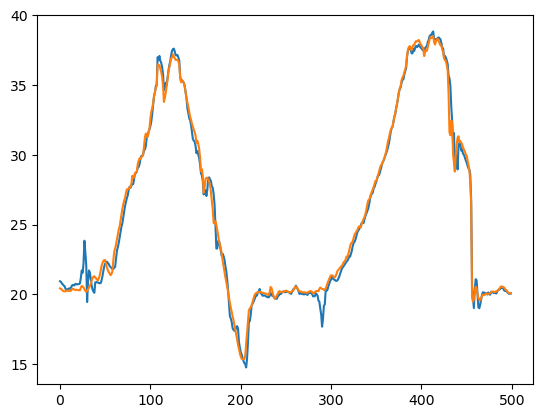

In [29]:
plt.plot([pred[0] * col_params[('temperatures', 'TA01_GT10X_GM10X')]['std'] + col_params[('temperatures', 'TA01_GT10X_GM10X')]['mean'] for pred in lstm_preds[:500]])
plt.plot(targets_test[:500, 0] * col_params[('temperatures', 'TA01_GT10X_GM10X')]['std'] + col_params[('temperatures', 'TA01_GT10X_GM10X')]['mean'])

In [30]:
n = 500

In [31]:
prev_max, prev_min = 99, 0
prev_range = 99 - 0
ta01_range = ta01_max - ta01_min
ta02_range = ta02_max - ta02_min

In [32]:
#preds[(ta01+1) * k + ta02+1]

In [33]:
# rescale TA01 flow
ta01_flow = ((np.array([flow[0] for flow in flow_list[:n]]) - prev_min) * ta01_range / prev_range) + ta01_min
ta02_flow = ((np.array([flow[1] for flow in flow_list[:n]]) - prev_min) * ta02_range / prev_range) + ta02_min

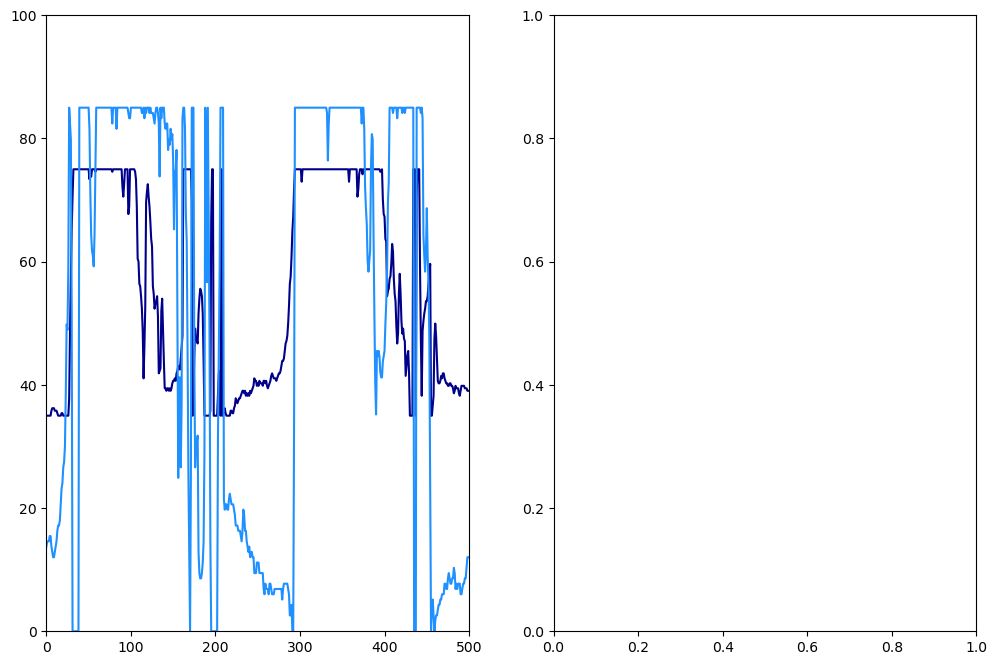

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 8)

n = 500

ax1.plot(ta01_flow, color='darkblue')
ax1.plot(ta02_flow, color='dodgerblue')
ax1.set_xlim(0, n)
ax1.set_ylim(0, 100)




plt.show()